In [103]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from datetime import datetime
import math

In [104]:
###################################################################################
###         convert dates and times of manual controls to timestamps            ###
###################################################################################

year = 2021
month = 6
day = [3, 4, 5, 7, 8, 9, 14]
hour = [22, 10, 9, 8, 11, 10, 9]
minutes = [55, 29, 22, 41, 20, 21, 4]
seconds = 0
timestamps = []

if len(day) == len(hour) == len(minutes):
    for i in range(len(day)):
        time = datetime(year, month, day[i], hour[i], minutes[i], seconds)
        timestamp = time.timestamp()
        timestamps.append(timestamp)
        print(time, 'hat den Timestamp', timestamp)

else:
    print('ungleiche Zahl an Tagen, Stunden & Minuten')

timestamps = np.array(timestamps)

#######################################################################
###         list of wort rest in beer (manual messurement)          ###
#######################################################################

wort_rest = [12, 11.6, 10.1, 6.6, 5.1, 3.5, 2.9]
print(len(wort_rest))
print(len(timestamps))

2021-06-03 22:55:00 hat den Timestamp 1622753700.0
2021-06-04 10:29:00 hat den Timestamp 1622795340.0
2021-06-05 09:22:00 hat den Timestamp 1622877720.0
2021-06-07 08:41:00 hat den Timestamp 1623048060.0
2021-06-08 11:20:00 hat den Timestamp 1623144000.0
2021-06-09 10:21:00 hat den Timestamp 1623226860.0
2021-06-14 09:04:00 hat den Timestamp 1623654240.0
7
7


In [105]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud2 - Kopie.json'

time=[]
pressure=[]
airflow=[]
with open (file_data) as f:
    for line in f:
        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        pressure_dict=fermentation['pressure']
        pressure.append(pressure_dict['bar'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])

###########################################################
###         transofrm data into numpy arrays            ###
###########################################################

time = np.array(time)
time = np.multiply(0.001, time).round(decimals=0)   # transform timestamps from milliseconds to seconds
pressure = np.array(pressure)
airflow = np.array(airflow)

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

time shape: (198915,)
pressure shape: (198915,)
airflow shape: (198915,)


In [106]:
###########################################################################################################
###         delete first and last values of arrays before start and after end of fermentation           ###
###########################################################################################################

time = time[20263:191424]
pressure = pressure[20263:191424]
airflow = airflow[20263:191424]
print(time[0])          # prüfe, dass wirklich mit richtigem timestamp gestartet wird
print(time[-1])         # prüfe, dass wirklich mit richtigem timestamp geendet wird

1622795032.0
1623654239.0


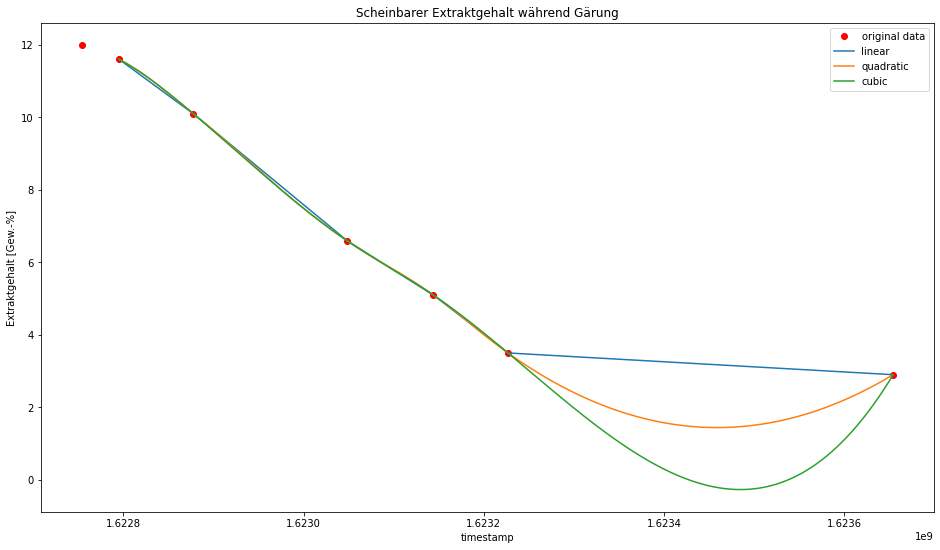

In [107]:
#######################################################
###         interpolation for wort values           ###
#######################################################

plt.figure(figsize=(16,9))
plt.title('Scheinbarer Extraktgehalt während Gärung')
plt.plot(timestamps, wort_rest, 'ro', label='original data')

for kind in ['linear', 'quadratic', 'cubic']:
    f = interpolate.interp1d(timestamps, wort_rest, kind=kind)          # versch. Interpolation der gemessenen Werte
    plt.plot(time, f(time), label=kind)                                 # interpolierter Wert für jeden Zeitpunkt über die Zeit darstellen

plt.xlabel('timestamp')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.legend()
plt.show()

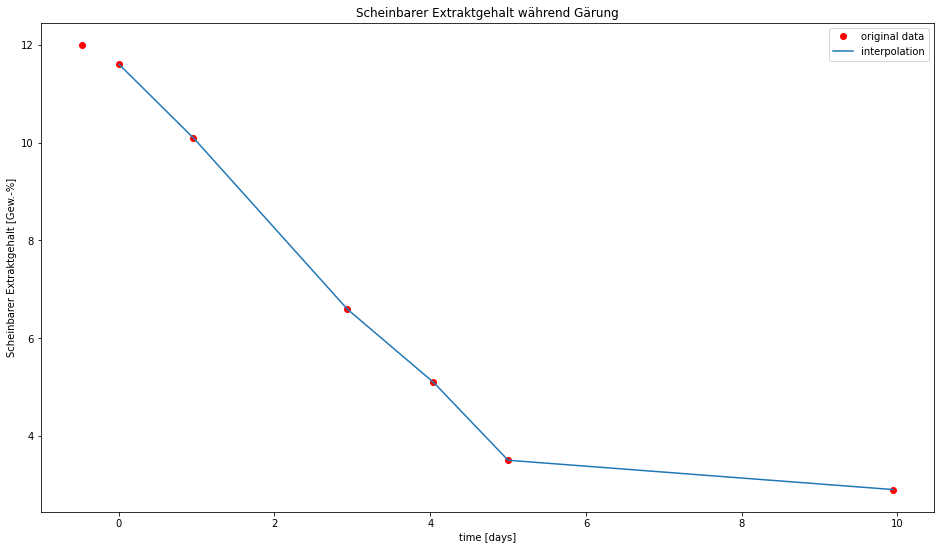

In [108]:
#############################################################
###         final interpolation for wort values           ###
#############################################################

time_seconds = time - 1622795032                                               # first timestamp should be zero
time_days = np.multiply(1.157416667e-5, time_seconds).round(decimals=3)

# ----------------------------------------------------------------

timestamps_seconds = timestamps - 1622795032                                               # timestamps should have same scale as time
timestamps_days = np.multiply(1.157416667e-5, timestamps_seconds).round(decimals=3)
# ----------------------------------------------------------------

f = interpolate.interp1d(timestamps_days, wort_rest, kind='linear')

plt.figure(figsize=(16,9))
plt.title('Scheinbarer Extraktgehalt während Gärung')
plt.plot(timestamps_days, wort_rest, 'ro', label='original data')
plt.plot(time_days, f(time_days), label='interpolation')
plt.xlabel('time [days]')
plt.ylabel('Scheinbarer Extraktgehalt [Gew.-%]')
plt.legend()
plt.show()

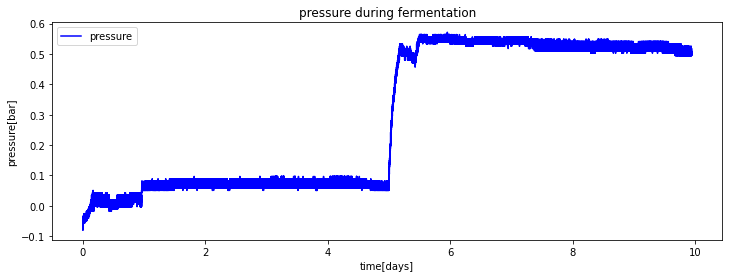

In [109]:
plt.figure(figsize=(12,4))
plt.title('pressure during fermentation')
plt.plot(time_days,pressure, color="blue", label="pressure")
plt.xlabel('time[days]')
plt.ylabel('pressure[bar]')
plt.legend()
plt.show()

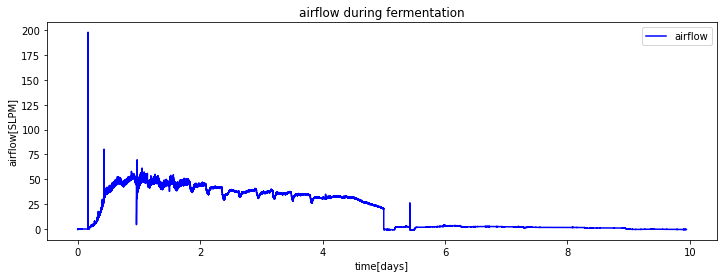

In [110]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days, airflow, color="blue", label="airflow")
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.legend()
plt.show()

In [111]:
########################################################################
###        Ausreißer der Druck- und Durchfluss-Werte finden          ###
########################################################################


print(np.amax(airflow))
print(airflow.argmax(axis=0))
print(airflow[2850])
print(airflow[2950])

print(np.amax(pressure))
print(pressure.argmax(axis=0))

198.0988
2895
-0.112915
-0.128174
0.571243
102468


In [112]:
#####################################################################################
###         calculations with arrays to create more arrays of input data          ###
#####################################################################################

pressure = pressure.clip(min=0.001)                 # set values to minimum 0,001 bar                
airflow = airflow.clip(min=0)                       # set negativ values to zero
airflow[2850:2950]=0  
# ----------------------------------------------------------------

# airflow = np.multiply(0.32, airflow)
# airflow = airflow.round(decimals=2)
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=2)        # *(5/60) -> Standart Liter per 5 secondes
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow in airflow_sum
airflow_diff = np.diff(airflow_5s)                                          # difference of airflow values to the next one
airflow_diff = np.insert(airflow_diff, 0, 0)                                # insert beginning zero for same size of array

# ----------------------------------------------------------------
pressure[89468:] = 0.571 
pressure = pressure.round(decimals=3)

##########################################################################################
###         find position of current temperature, set temperature, set pressure        ###
##########################################################################################
 
# print(np.where(time==1622795032)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur und Ist_temperatur 8°C beträgt
# print(np.where(time==1622795343)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 10°C und Ist-Temperatur 9,5°C beträgt
# print(np.where(time==1622877718)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur und Ist-Temperatur 11°C beträgt
# print(np.where(time==1623226859)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 14°C und Ist-Temperatur 12,5°C beträgt

#######################################################################################################
###         create arrays for current temperature, temperature setpoint & pressure setpoint         ###
#######################################################################################################

temperature = np.full_like(time_days, 1)
temperature[:62] = 8
temperature[62:16475] = 9.5
temperature[16475:86022] = 11
temperature[86022:146003] = 12.5
temperature[-8000:] = 14

# ----------------------------------------------------------------

temperature_set = np.full_like(time_days, 1)
temperature_set[:62] = 8
temperature_set[62:16475] = 10
temperature_set[16475:86022] = 11
temperature_set[86022:] = 12

# ----------------------------------------------------------------

pressure_set = np.full_like(time_days, 0)

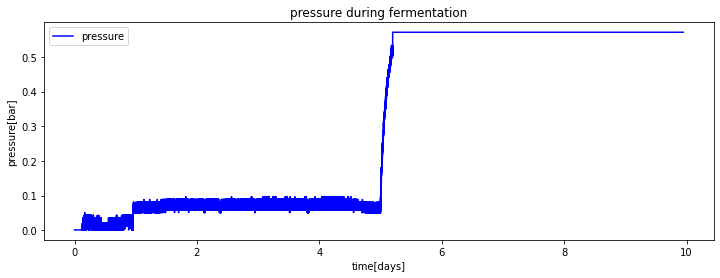

In [113]:
plt.figure(figsize=(12,4))
plt.title('pressure during fermentation')
plt.plot(time_days,pressure, color="blue", label="pressure")
plt.xlabel('time[days]')
plt.ylabel('pressure[bar]')
plt.legend()
plt.show()

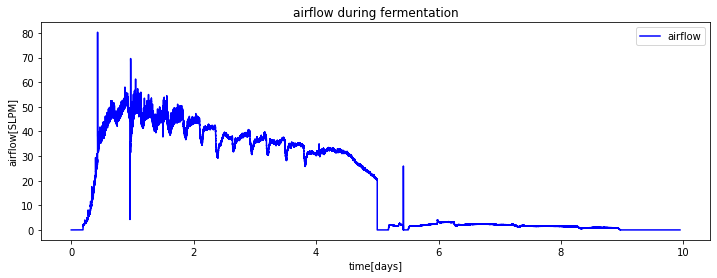

In [114]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days, airflow, color="blue", label="airflow")
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.legend()
plt.show()

In [115]:
###########################################
###         Extraktberechnung           ###
###########################################

# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass = np.full_like(time_days, 1)
flow_mass_total = np.full_like(time_days, 1)
air_mass = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar_1 = np.full_like(time_days, 1)

flow_mass_calc = np.full_like(time_days, 1)
flow_mass_total_calc = np.full_like(time_days, 1)
airflow_5s_calc = np.full_like(time_days, 1)
extraktgehalt_calc = np.full_like(time_days, 1)
extraktgehalt_scheinbar_interp = np.full_like(time_days, f(time_days))

# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 12                                            # Stammwürze [°P]
wuerze_mass = 995.6                                # mass of wort [kg]
wuerze_volume = 2                                   # Würzevloumen [m^3]
air_volume = 400                                   # Luftvolumen [l]
extract_mass_start = SW * wuerze_mass / 100         # Startextrakt in [kg] aus Stammwürze und Masse der Würze
mol_mass = 44.01                                    # Molare Masse von CO2 in [g/mol]
henry_const = 0.0338                                # Henry-Konstante für CO2 [mol/(l*bar)]

# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    temperature_kelvin = temperature[i] + 273.15                                        # Temperatur [K]

    # ---------- ausströmendes CO2 ----------------------------------------------------------------------------------------------------------------
    density = (pressure[i]*100000)/(188.9*(temperature_kelvin))                   # Dichte aus iG-Gesetz [kg/m^3] (100000 - Umrechnung Pascal, 188.9 - Gaskonstante CO2)
    flow_mass[i] = airflow_5s[i] * density * 0.001                                      # Masse des Durchfluss der letzten 5s [kg]
    if i == 0:
        flow_mass_total[i] = flow_mass[i]
    else:    
        flow_mass_total[i] = flow_mass_total[i-1] + flow_mass[i]                        # gesamtes ausgeströmtes CO2 [kg]
    
    # ---------- im Bier gelöstes CO2 -------------------------------------------------------------------------------------------------------------
    temp_compensation = math.exp(2400*((1/temperature_kelvin) - (1/298.15)))         # Temperaturkompensation für Henrygesetz errechnen
    henry_coefficient = henry_const*temp_compensation                                 # Henry-Koeffizient für CO2 [mol/(l*bar)]
    CO2__concentration = henry_coefficient*pressure[i]                                # Stoffkonzentration in Flüssigkeit über Henry-Gesetz [mol/l]
    gas_in_liquid_mass[i] = mol_mass * wuerze_volume * CO2__concentration               # CO2 im Bier gelöst [kg]

    # ---------- im Tank über dem Bier stehendes CO2 ----------------------------------------------------------------------------------------------
    air_mass[i] = (pressure[i]*100000*air_volume*0.001)/(188.9*temperature_kelvin)      # CO2 im Tank iG-Gesetz [kg] (Beachte Umrechnung bar -> Pa, l -> m^3)
    
    # ---------- GESAMT ---------------------------------------------------------------------------------------------------------------------------
    total_co2_mass[i] = flow_mass_total[i] + air_mass[i] + gas_in_liquid_mass[i]                                        # gesamt erzeugtes CO2 [kg]
    extract_mass_converted[i] = total_co2_mass[i]/0.463                                                               # umgesetzter Extrakt [kg]
    extraktgehalt[i] = ((extract_mass_start - extract_mass_converted[i])*100)/(wuerze_mass - (flow_mass_total[i]+air_mass[i]))      # Restextraktgehalt [°P]
    # extraktgehalt_scheinbar_1[i] = extraktgehalt[i] * (1 + q) + SW * q                                                  # scheinbarer Extraktgehalt [°P]
    extraktgehalt_scheinbar_1[i] = (extraktgehalt[i] - (0.1808*SW))/0.8192                           # scheinbarer Extraktgehalt [°P]

    # ---------- umgekehrte Berechnung des ausströmenden CO2s -------------------------------------------------------------------------------------
    extraktgehalt_calc[i] = (extraktgehalt_scheinbar_interp[i]*0.8192) + (0.1808*SW)                # Umrechnung aus Brauwelt: wahr <--> scheinbar
    a = extract_mass_start*0.463
    b = air_mass[i]
    c = gas_in_liquid_mass[i]
    d = wuerze_mass
    e = (extraktgehalt_calc[i]/100)*0.463
    x = a + (b*(e-1)) - c - (d * e)                                                     # berechnetes Equivalent zu flow_mass_total[i]
    flow_mass_total_calc[i] = x

    if i == 0:
        flow_mass_calc[i] = flow_mass_total_calc[i]
    else:    
        flow_mass_calc[i] = flow_mass_total_calc[i] - flow_mass_total_calc[i-1]

    airflow_5s_calc[i] = flow_mass_calc[i]/(density*0.001)

print('mass extract before fermantation:', extract_mass_start, 'kg \n')
print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_total[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass[-1], 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg')
print('Extraktgehalt Start:', extraktgehalt[0], '°P')
print('Extraktgehalt Ende:', extraktgehalt[-1], '°P')
print('Extraktgehalt scheinbar Start:', extraktgehalt_scheinbar_1[0], '°P')
print('Extraktgehalt scheinbar Ende:', extraktgehalt_scheinbar_1[-1], '°P')
print('Extrakt umgesetzt:',extract_mass_converted[-1], 'kg \n')

print('ausgeströmtes Gas-Gewicht gesamt:',flow_mass_total_calc[-1], 'kg')
print('Extraktgehalt berechnet Start:', extraktgehalt_calc[0], '°P')
print('Extraktgehalt berechnet Ende:', extraktgehalt_calc[-1], '°P')
print('Extraktgehalt scheinbar Start:', extraktgehalt_scheinbar_interp[0], '°P')
print('Extraktgehalt scheinbar Ende:', extraktgehalt_scheinbar_interp[-1], '°P \n')

mass extract before fermantation: 119.47200000000001 kg 

mass of total CO2 flow (outside tank) after fermantation: 35.84764141559541 kg
mass of CO2 above liquid in tank: 0.42107098963757933 kg
mass of CO2 in liquid after fermantation: 2.3123518351851673 kg
total mass of CO2 after fermantation: 38.58106424041816 kg
Extraktgehalt Start: 11.998795623165286 °P
Extraktgehalt Ende: 3.7675793526879158 °P
Extraktgehalt scheinbar Start: 11.998529813434187 °P
Extraktgehalt scheinbar Ende: 1.9506583895116159 °P
Extrakt umgesetzt: 83.32843248470444 kg 

ausgeströmtes Gas-Gewicht gesamt: 31.638924509423475 kg
Extraktgehalt berechnet Start: 11.675039336099584 °P
Extraktgehalt berechnet Ende: 4.54528 °P
Extraktgehalt scheinbar Start: 11.603319502074688 °P
Extraktgehalt scheinbar Ende: 2.9 °P 



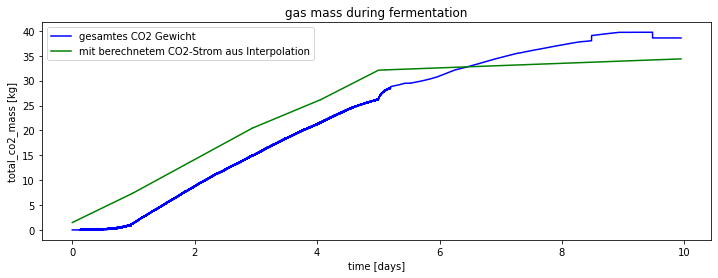

In [116]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="gesamtes CO2 Gewicht")
plt.plot(time_days, (flow_mass_total_calc + air_mass + gas_in_liquid_mass), color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('total_co2_mass [kg]')
plt.legend()
plt.show()

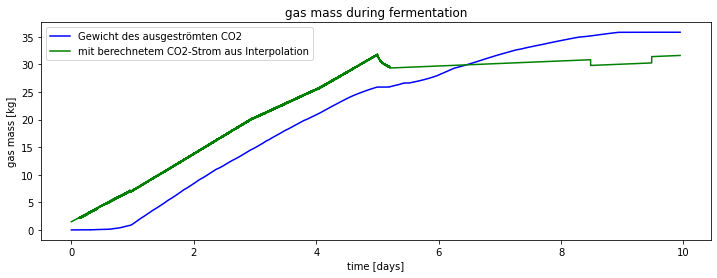

In [117]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass_total, color="blue", label="Gewicht des ausgeströmten CO2")
plt.plot(time_days, flow_mass_total_calc, color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

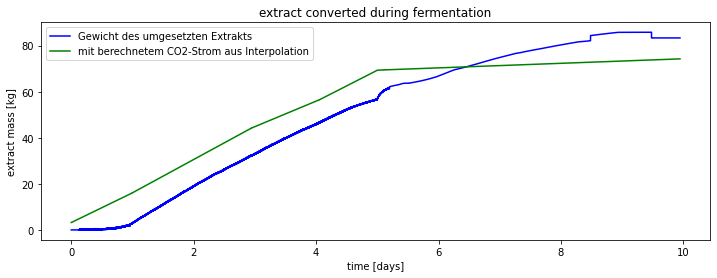

In [118]:
plt.figure(figsize=(12,4))
plt.title('extract converted during fermentation')
plt.plot(time_days, extract_mass_converted, color="blue", label="Gewicht des umgesetzten Extrakts")
plt.plot(time_days, (flow_mass_total_calc + air_mass + gas_in_liquid_mass)/0.463, color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract mass [kg]')
plt.legend()
plt.show()

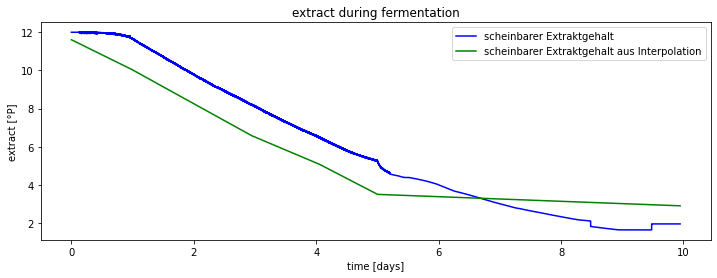

In [119]:
plt.figure(figsize=(12,4))
plt.title('extract during fermentation')
plt.plot(time_days, extraktgehalt_scheinbar_1, color="blue", label="scheinbarer Extraktgehalt")
plt.plot(time_days, extraktgehalt_scheinbar_interp, color="green", label="scheinbarer Extraktgehalt aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract [°P]')
plt.legend()
plt.show()

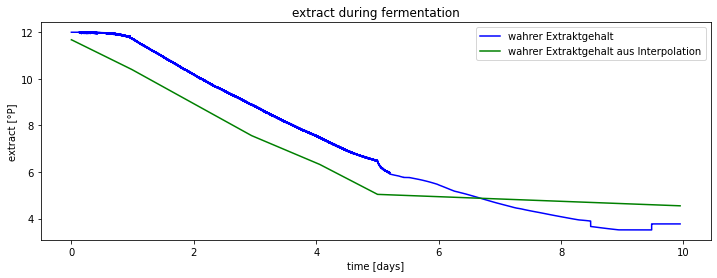

In [120]:
plt.figure(figsize=(12,4))
plt.title('extract during fermentation')
plt.plot(time_days, extraktgehalt, color="blue", label="wahrer Extraktgehalt")
plt.plot(time_days, extraktgehalt_calc, color="green", label="wahrer Extraktgehalt aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract [°P]')
plt.legend()
plt.show()